In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import pandas as pd
import os
import sys
import scipy
from scipy import stats
import matplotlib.dates as mdates
from datetime import datetime
from iminuit import Minuit
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *

In [2]:
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/Data/MA200/Raw data/visibuilt_day1 2024/'

data = read_csv_BC(path, parent_path, 0)

HEPA_keys = ['MA200-0285_240910101601', 'MA200-0353_240910103200', 'MA200-0369_240910101605']
conc_keys = ['Sample temp (C)', 'Sample RH (%)', 'Sample dewpoint (C)', 
             'UV BCc', 'Blue BCc', 'Green BCc', 'Red BCc', 'IR BCc']
ylabels = ['Sample T / $^{\circ}$C', 'Sample RH / %', 'Sample DP / $^{\circ}$C', 
           'UV BC / $\mu$g m$^{-3}$', 'Blue BC / $\mu$g m$^{-3}$', 'Green BC / $\mu$g m$^{-3}$', 
           'Red BC / $\mu$g m$^{-3}$', 'IR BC / $\mu$g m$^{-3}$']
colors = ['tab:red', 'tab:blue', 'tab:cyan', 'darkviolet', 'blue', 'green', 'red', 'k']
line_styles = ['-', ':', '--']

c:\Users\B363580\Documents\GitHub\Master-thesis\calibration\..\plot_functions.py:297: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")
C:\Users\B363580\AppData\Local\Temp\ipykernel_6652\871869841.py:12: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


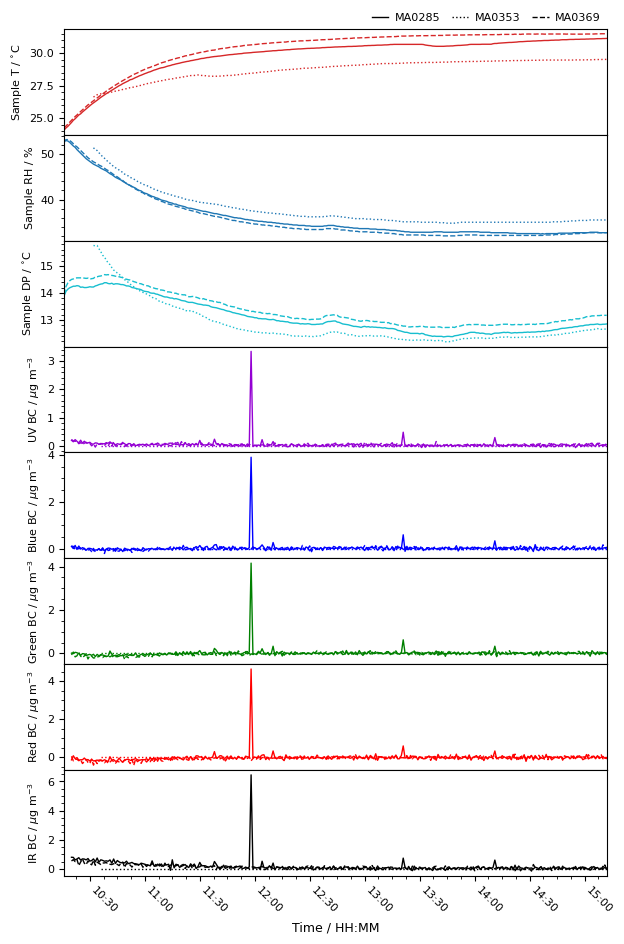

In [3]:
fig = plt.figure(figsize = (7, 11))
gs = fig.add_gridspec(8, hspace=0)
ax = gs.subplots(sharex=True)

for i, df_key in enumerate(conc_keys):
    for ls, dict_key in zip(line_styles, HEPA_keys):
        plot_total(ax[i], data[dict_key], df_key, colors[i], ls)
        ax[i].set_ylabel(ylabels[i], fontsize = 8)

ax[7].legend(labels = ['MA0285', 'MA0353', 'MA0369'], bbox_to_anchor = (0, 7.2, 1, 1), ncol = 3, fontsize = 8)

fig.tight_layout()
fig.savefig('HEPA_timeseries.png', dpi = 600)

In [8]:
def MA_correction_single(ax, xval, yval, guess):
    
    fit_params, fit_errors, squares, ndof, R2 = linear_fit(xval, yval, linear, a_guess = guess[0], b_guess = guess[1])
    a, b = fit_params[0], fit_params[1]
    y_fit = a*xval + b

    ax.plot(xval, y_fit, lw = 1.2)
    ax.scatter(xval, yval, s = 10, alpha = 0.5)

    return a, b, R2

def MA_correction_multi(ax, df, keys, xlabels, guess):
    a_array = np.zeros(len(keys))
    b_array = np.zeros(len(keys))
    R2_array = np.zeros(len(keys))

    for i, key in enumerate(keys):
        delta = np.array(df[key][1:]) - np.array(df[key][:-1])

        a, b, R2 = MA_correction_single(ax[0][i], df[key], df['IR BCc'], guess[i])
        print(f'{key}: f(x) = {a}x + {b}, R2 = {R2}')
        a_array[i] += a
        b_array[i] += b
        R2_array[i] += R2
        ax[0][i].set(xlabel = xlabels[0][i], ylabel = 'IR BC / $\mu$g m$^{-3}$')

        ax[1][i].scatter(delta, df['IR BCc'][1:], s = 10, alpha = 0.5)
        ax[1][i].set(xlabel = xlabels[1][i], ylabel = 'IR BC / $\mu$g m$^{-3}$')

    return a_array, b_array, R2_array

Sample temp (C): f(x) = -0.11x + 3.45, R2 = nan
Sample RH (%): f(x) = 0.035x + -1.2, R2 = nan
Sample dewpoint (C): f(x) = 0.2x + -2.5, R2 = nan
Sample temp (C): f(x) = -0.11x + 3.45, R2 = nan
Sample RH (%): f(x) = 0.035x + -1.2, R2 = nan
Sample dewpoint (C): f(x) = 0.2x + -2.5, R2 = nan


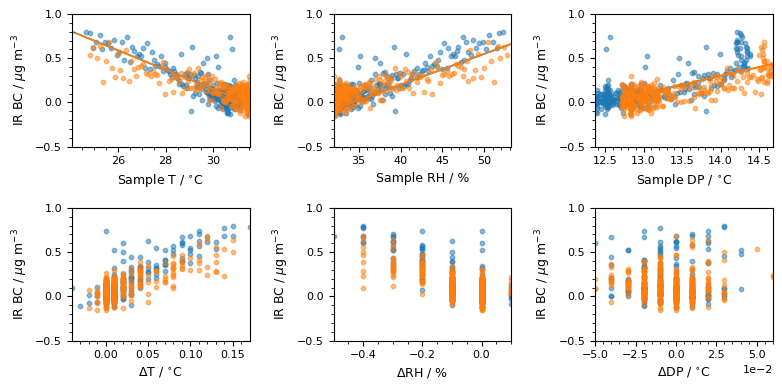

In [9]:
x_labels = [['Sample T / $^{\circ}$C', 'Sample RH / %', 'Sample DP / $^{\circ}$C'],
            ['$\Delta$T / $^{\circ}$C', '$\Delta$RH / %', '$\Delta$DP / $^{\circ}$C']]
guess = [[-0.11, 3.45],
         [0.035, -1.2],
         [0.2, -2.5]]

fig, axs = plt.subplots(2, 3, figsize = (8, 4))

for key in [HEPA_keys[0], HEPA_keys[2]]:
    df = data[key]

    MA_correction_multi(axs, df, conc_keys[:3], x_labels, guess)

# axs[0][1].legend(labels = ['MA0285', 'MA0285 fit', 'MA0353', 'MA0353 fit', 'MA0369', 'MA0369 fit'], bbox_to_anchor = (0.05, 0.2, 1, 1), ncol = 6, fontsize = 8)
for ax in axs.flatten():
    ax.set_ylim(-0.5, 1)

fig.tight_layout()